In [4]:
library(tidyverse)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [6]:
csq = read_tsv("output/freebayes_at9852_ath_filt-q100-ac10-dp100-200k-only1k1g-csq_onlyNLRs_csqtab_geneids.tsv",
              col_names=c("chrom", "pos", "alt", "qual", "af", "bcsq", "gene_id"), na=".")

Rows: 101617 Columns: 7
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, alt, bcsq, gene_id
dbl (3): pos, qual, af

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
glimpse(csq)

Rows: 101,617
Columns: 7
$ chrom   <chr> "at9852_1_chr1", "at9852_1_chr1", "at9852_1_chr1", "at9852_1_c…
$ pos     <dbl> 3151589, 3151591, 3151613, 3151637, 3151662, 3151662, 3151671,…
$ alt     <chr> "C", "C", "A", "A", "C", "*", "G", "*", "A", "*", "G", "G", "C…
$ qual    <dbl> 5386.120, 5386.120, 489.192, 16241.100, 656307.000, 656307.000…
$ af      <dbl> 0.01556750, 0.00251088, 0.00181938, 0.01297410, 0.22569700, NA…
$ bcsq    <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "missense|at9852_G…
$ gene_id <chr> "at9852_G009400", "at9852_G009400", "at9852_G009400", "at9852_…


In [31]:
csq2 = csq %>%
    filter(!is.na(bcsq), !grepl("^@", bcsq)) %>%
    mutate(bcsq=sub(",.*", "", bcsq)) %>%
    separate_wider_delim(bcsq, "|", names=c("csqtype", "gene", "transcript", "genetype", "strand", "aa", "cds"), too_few="debug", too_many="debug") %>%
    select(gene_id, chrom, pos, alt, qual, af, csqtype) %>%
    mutate(csqtype=sub("&.*", "", csqtype)) %>%
    filter(!grepl("^\\*", csqtype)) %>%
    group_by(gene_id) %>%
    mutate(genepos = (pos - min(pos)) / ( max(pos)-min(pos)))
write_csv(csq2, "output/summarised_csq_pergene.csv", na="")

Warning message:
“Debug mode activated: adding variables `bcsq_ok`, `bcsq_pieces`, and `bcsq_remainder`.”


In [9]:
table(csq2$csqtype)


      3_prime_utr       5_prime_utr   coding_sequence        frameshift 
             6909              3070                 1               577 
 inframe_deletion inframe_insertion            intron          missense 
              252               172             13523             27306 
  splice_acceptor      splice_donor     splice_region        start_lost 
               49                42              1268                18 
      stop_gained         stop_lost     stop_retained        synonymous 
              372                19                 2             14426 

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


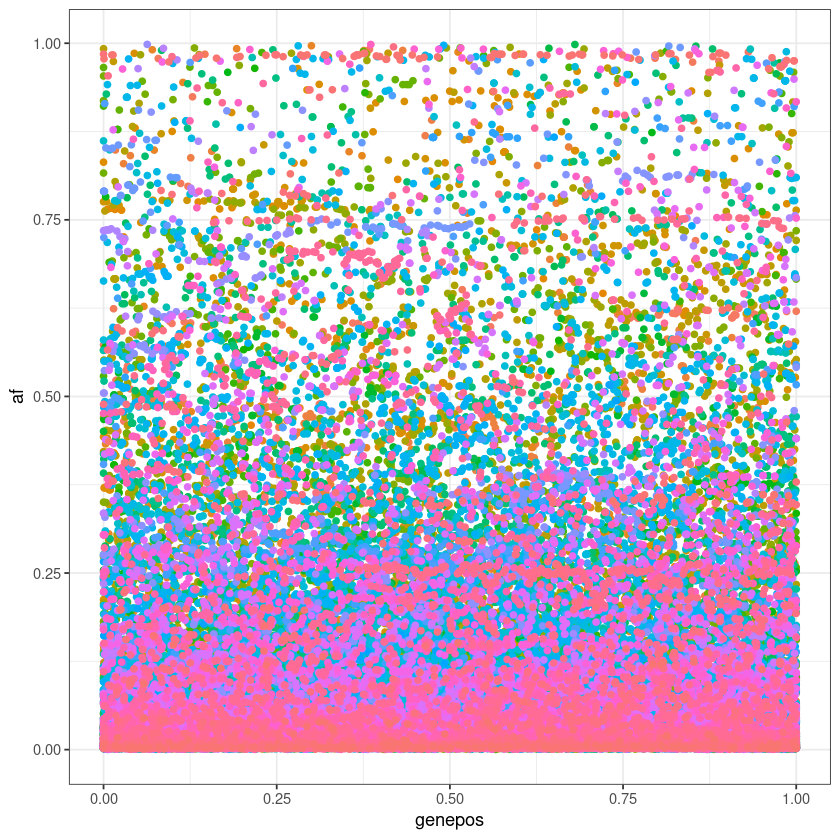

In [10]:
ggplot(csq2, aes(x=genepos, y=af)) +
    geom_point(aes(colour=gene_id)) +
    guides(colour=guide_none()) +
    theme_bw() +
    theme()

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


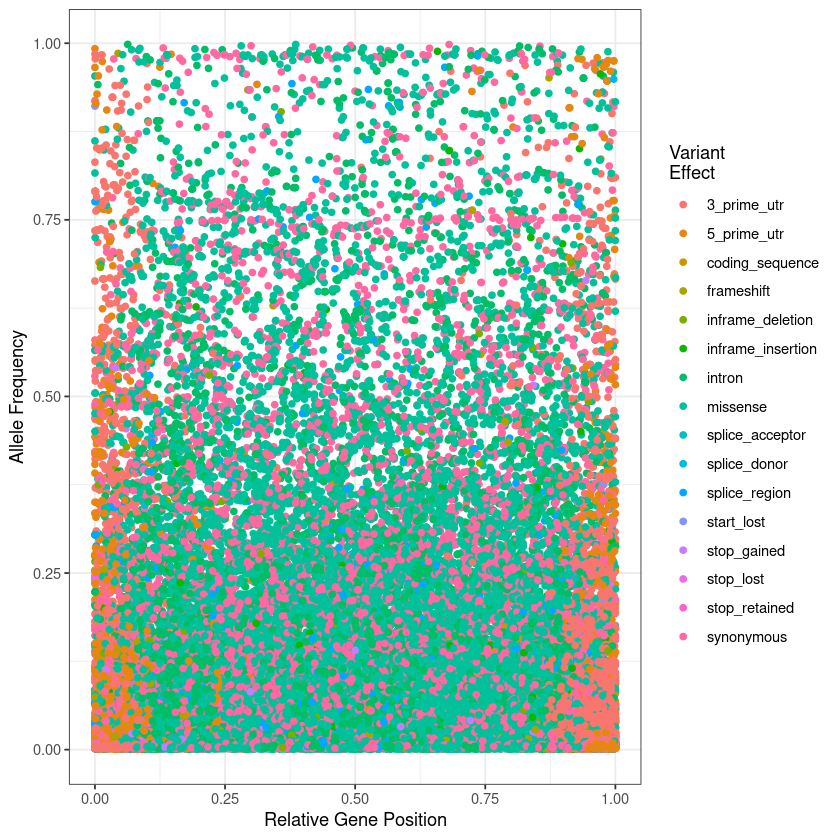

In [11]:
ggplot(csq2, aes(x=genepos, y=af)) +
    geom_point(aes(colour=csqtype)) +
    labs(x="Relative Gene Position", y="Allele Frequency", colour="Variant\nEffect")+
    theme_bw() +
    theme()

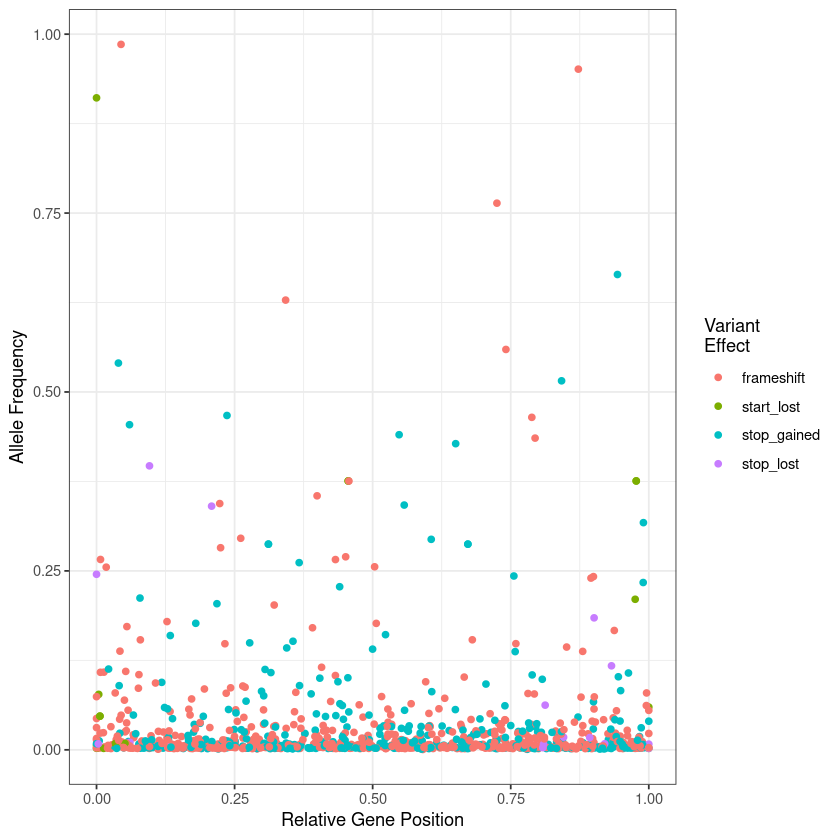

In [12]:
csq2 %>%
    filter(csqtype %in% c("frameshift", "stop_gained", "feature_elongation", "start_lost", "stop_gained", "stop_lost"))%>%
ggplot(aes(x=genepos, y=af)) +
    geom_point(aes(colour=csqtype)) +
    labs(x="Relative Gene Position", y="Allele Frequency", colour="Variant\nEffect")+
    theme_bw() +
    theme()

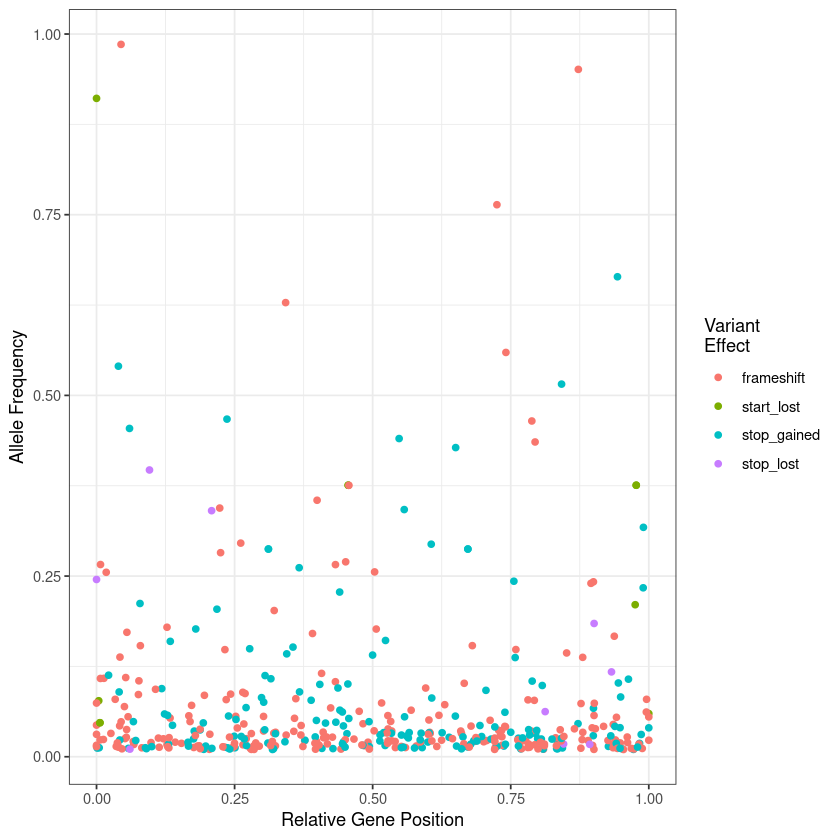

In [13]:
csq2 %>%
    filter(csqtype %in% c("frameshift", "stop_gained", "feature_elongation", "start_lost", "stop_gained", "stop_lost"))%>%
    filter(af>0.01) %>%
ggplot(aes(x=genepos, y=af)) +
    geom_point(aes(colour=csqtype)) +
    labs(x="Relative Gene Position", y="Allele Frequency", colour="Variant\nEffect")+
    theme_bw() +
    theme()

In [14]:
library(ggridges)

Picking joint bandwidth of 0.0224



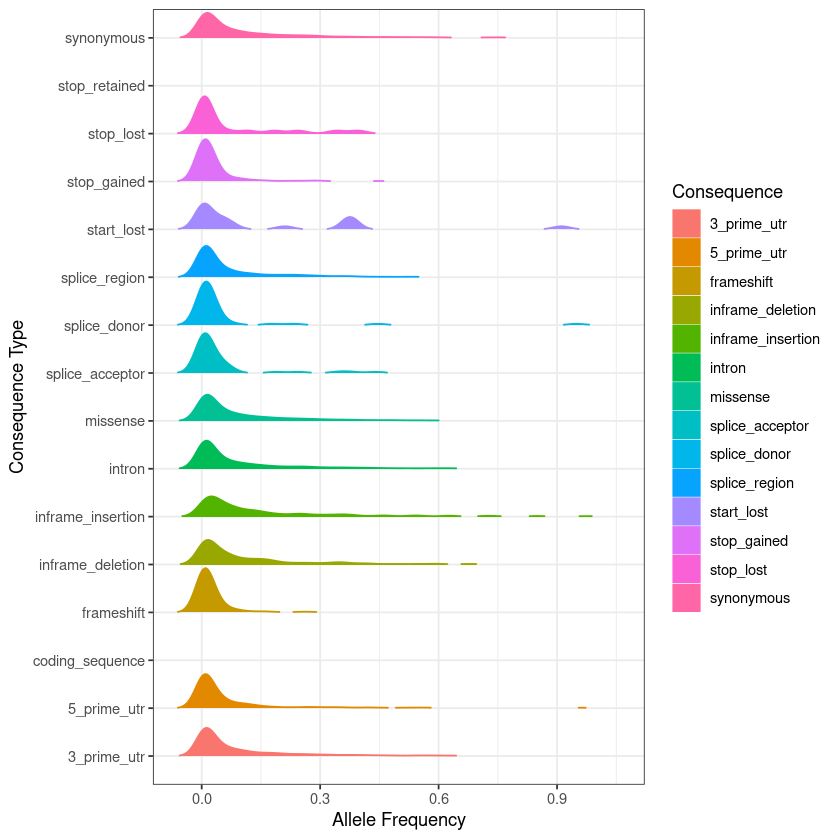

In [29]:
gcons = guide_legend(title="Consequence")
csq2 %>%
ggplot(aes(x=af, y=csqtype)) +
    geom_density_ridges(aes(fill=csqtype, colour=csqtype), scale=0.8, rel_min_height = 0.01, panel_scaling = F) +
    labs(y="Consequence Type",x="Allele Frequency") +
    guides(fill=gcons, colour=gcons) +
    theme_bw() +
    theme()